In [ ]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error,silhouette_score
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb

from model_evaluation_utils import evaluate_and_plot

# Veri Yükleme

In [2]:
data = fetch_openml(data_id=43837, as_frame=True)
df = data.frame

# Veriyi İnceleme ve Analiz

In [3]:
df.head()

,Unnamed:_0,size_sq_ft,propertyType,bedrooms,latitude,longitude,localityName,suburbName,cityName,price,companyName,closest_mtero_station_km,AP_dist_km,Aiims_dist_km,NDRLW_dist_km
0,0,400,'Independent Floor',1,28.641010,77.284386,'Swasthya Vihar','Delhi East',Delhi,9000,'Dream Homez',0.577495,21.741188,11.119239,6.227231
1,1,1050,Apartment,2,28.594969,77.298668,'mayur vihar phase 1','Delhi East',Delhi,20000,'Rupak Properties Stock',0.417142,21.401856,9.419061,9.217502
2,2,2250,'Independent Floor',2,28.641806,77.293922,'Swasthya Vihar','Delhi East',Delhi,28000,'Aashiyana Real Estate',0.125136,22.620365,11.829486,7.159184
3,3,1350,'Independent Floor',2,28.644363,77.293228,'Krishna Nagar','Delhi East',Delhi,28000,'Shivam Real Estate',0.371709,22.681201,11.982708,7.097348
4,4,450,Apartment,2,28.594736,77.311150,'New Ashok Nagar','Delhi East',Delhi,12500,'Shree Properties',1.087760,22.592810,10.571573,10.263271


In [4]:
df.drop("Unnamed:_0",axis=1 , inplace=True)

In [5]:
df.isnull().sum()

size_sq_ft                  0
propertyType                0
bedrooms                    0
latitude                    0
longitude                   0
localityName                0
suburbName                  0
cityName                    0
price                       0
companyName                 0
closest_mtero_station_km    0
AP_dist_km                  0
Aiims_dist_km               0
NDRLW_dist_km               0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17890 entries, 0 to 17889
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   size_sq_ft                17890 non-null  int64  
 1   propertyType              17890 non-null  object 
 2   bedrooms                  17890 non-null  int64  
 3   latitude                  17890 non-null  float64
 4   longitude                 17890 non-null  float64
 5   localityName              17890 non-null  object 
 6   suburbName                17890 non-null  object 
 7   cityName                  17890 non-null  object 
 8   price                     17890 non-null  int64  
 9   companyName               17890 non-null  object 
 10  closest_mtero_station_km  17890 non-null  float64
 11  AP_dist_km                17890 non-null  float64
 12  Aiims_dist_km             17890 non-null  float64
 13  NDRLW_dist_km             17890 non-null  float64
dtypes: flo

In [8]:
# kategorik ve sayısal değişkenleri belirleme
numeric_colums = df.select_dtypes(include='number').columns.tolist()
non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()

In [9]:
desc = df[numeric_colums].describe().T
pd.options.display.float_format = '{:,.2f}'.format
print(desc)

                             count      mean       std      min       25%  \
size_sq_ft               17,890.00  1,176.34    873.75   100.00    620.00   
bedrooms                 17,890.00      2.17      0.97     1.00      1.00   
latitude                 17,890.00     28.61      0.10    19.19     28.56   
longitude                17,890.00     77.17      0.10    73.21     77.10   
price                    17,890.00 33,451.96 88,020.54 1,200.00 13,500.00   
closest_mtero_station_km 17,890.00      0.93      8.29     0.00      0.46   
AP_dist_km               17,890.00     13.73     11.36     1.78     11.02   
Aiims_dist_km            17,890.00     11.24     11.17     0.63      7.77   
NDRLW_dist_km            17,890.00     11.42     11.06     0.72      7.99   

                               50%       75%          max  
size_sq_ft                  900.00  1,600.00    16,521.00  
bedrooms                      2.00      3.00        15.00  
latitude                     28.61     28.65     

In [10]:
df[non_numeric_cols].describe().T

,count,unique,top,freq
propertyType,17890,4,'Independent Floor',11218
localityName,17890,781,'Patel Nagar',1448
suburbName,17890,12,'Delhi South',3749
cityName,17890,1,Delhi,17890
companyName,17890,1387,Gurmeet,668


In [11]:
def fix_unit_mismatch(x):
    return x / 1000 if x > 10 else x

df['closest_mtero_station_km'] = df['closest_mtero_station_km'].apply(fix_unit_mismatch)
df['Aiims_dist_km'] = df['Aiims_dist_km'].apply(fix_unit_mismatch)
df['NDRLW_dist_km'] = df['NDRLW_dist_km'].apply(fix_unit_mismatch)

In [12]:
df[['closest_mtero_station_km','Aiims_dist_km','NDRLW_dist_km']].describe()

,closest_mtero_station_km,Aiims_dist_km,NDRLW_dist_km
count,"17,890.00","17,890.00","17,890.00"
mean,0.83,3.03,2.96
std,0.60,3.76,3.73
min,0.00,0.01,0.01
25%,0.46,0.02,0.01
50%,0.70,0.02,0.02
75%,1.08,6.78,6.63
max,6.56,10.00,10.00


# Veri Dönüşümleri Ve Özellik Ekleme

In [13]:
df.drop(columns=['cityName'], inplace=True)

In [14]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['suburbName'], prefix='suburb')
df = pd.get_dummies(df, columns=['propertyType'], prefix='property')

In [15]:
top_localities = df['localityName'].value_counts().head(20).index
df['localityName'] = df['localityName'].apply(lambda x: x if x in top_localities else 'other')
df = pd.get_dummies(df, columns=['localityName'], prefix='locality')
top_localities = df['companyName'].value_counts().head(20).index
df['companyName'] = df['companyName'].apply(lambda x: x if x in top_localities else 'other')
df = pd.get_dummies(df, columns=['companyName'], prefix='company')

In [16]:
coords = df[["latitude", "longitude"]]

silhouette_scores = []
k_values = range(2, 15)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(coords)
    score = silhouette_score(coords, labels)
    silhouette_scores.append(score)

best_k = k_values[silhouette_scores.index(max(silhouette_scores))]

best_kmeans = KMeans(n_clusters=best_k, random_state=42)
df["location_cluster"] = best_kmeans.fit_predict(coords)


# Görselleştirme

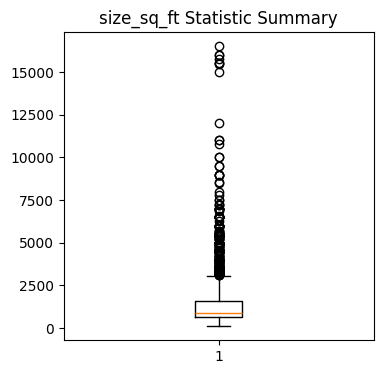

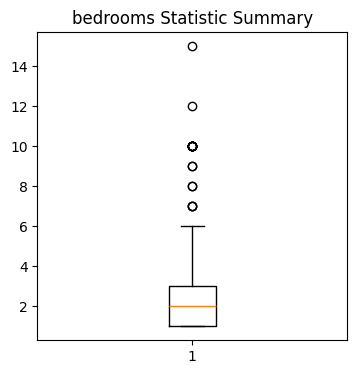

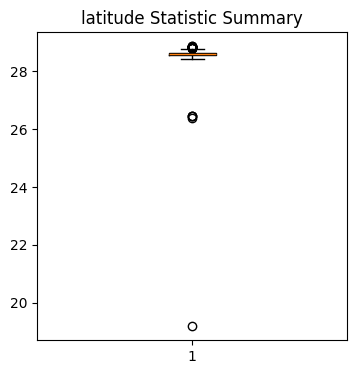

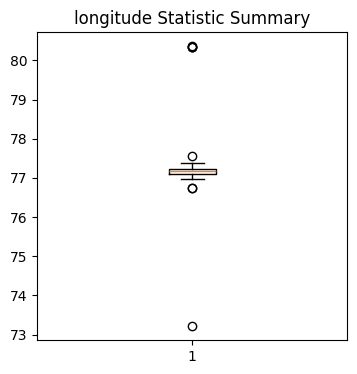

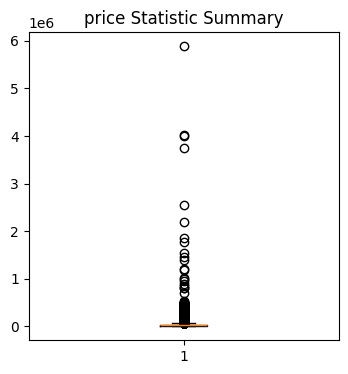

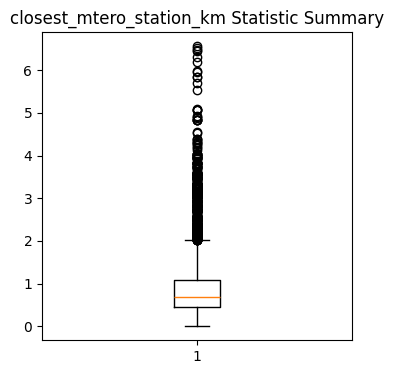

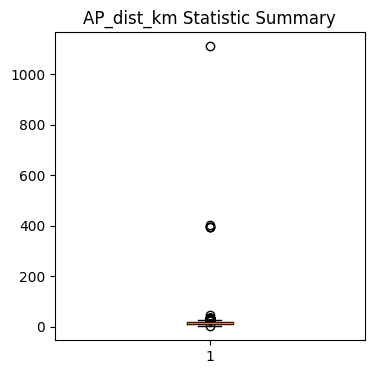

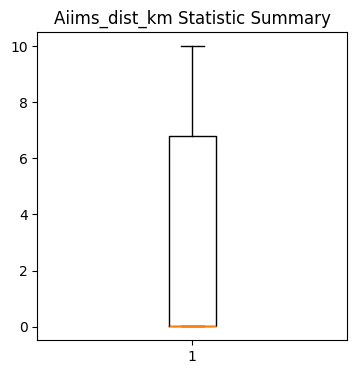

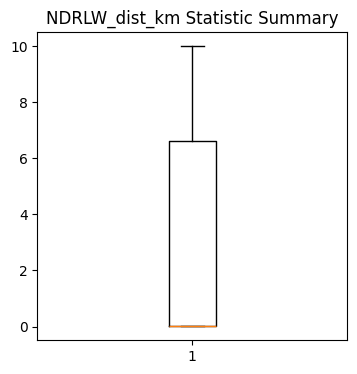

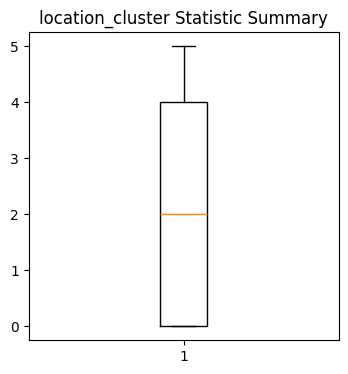

In [17]:
for i in df.select_dtypes(include='number').columns:
    fig, ax = plt.subplots(figsize=(4,4))
    ax.boxplot(df[i])
    ax.set_title(i+' Statistic Summary')
plt.show()

# Aykırı Değerlerin Tespiti

In [18]:
aykiri_sutunlar = []

for col in df.select_dtypes(include='number').columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    alt_sinir = Q1 - 1.5 * IQR
    ust_sinir = Q3 + 1.5 * IQR
    aykiri_sayisi = df[(df[col] < alt_sinir) | (df[col] > ust_sinir)].shape[0]
    
    if aykiri_sayisi > 0:
        aykiri_sutunlar.append((col, aykiri_sayisi))

# Sonuçları gör
for col, count in aykiri_sutunlar:
    print(f"{col} sütununda {count} aykırı değer var.")

size_sq_ft sütununda 441 aykırı değer var.
bedrooms sütununda 19 aykırı değer var.
latitude sütununda 32 aykırı değer var.
longitude sütununda 8 aykırı değer var.
price sütununda 1367 aykırı değer var.
closest_mtero_station_km sütununda 628 aykırı değer var.
AP_dist_km sütununda 67 aykırı değer var.


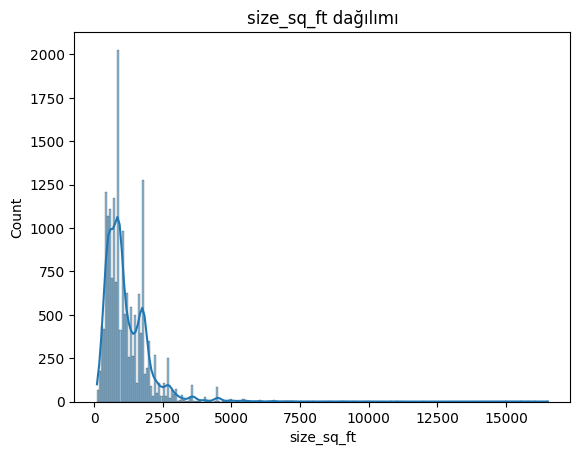

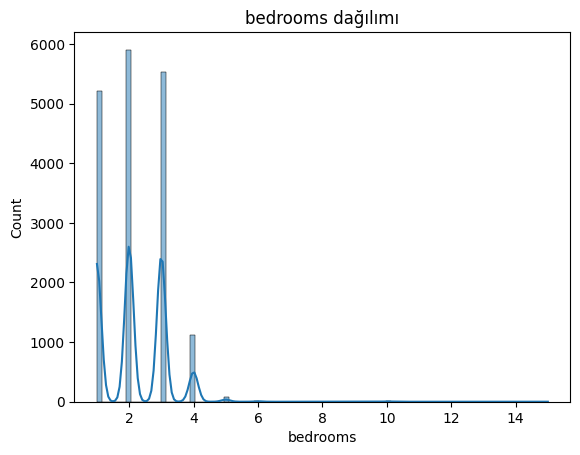

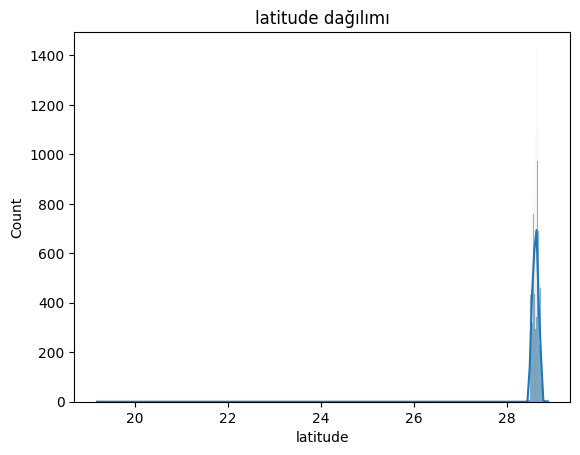

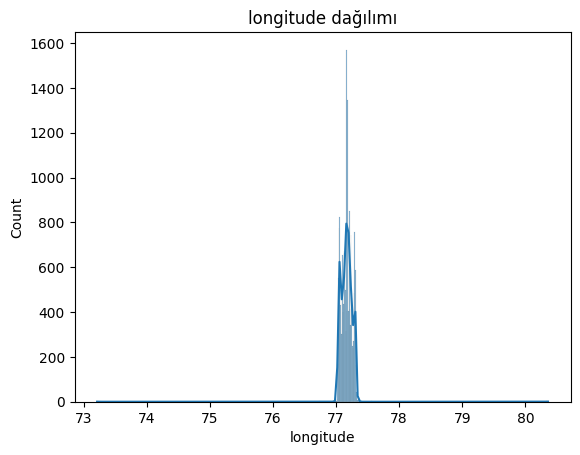

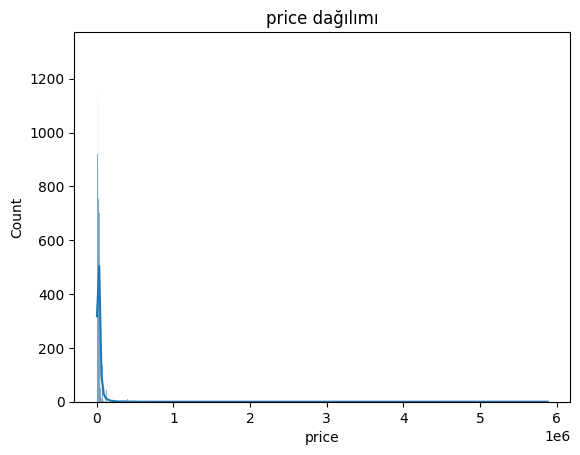

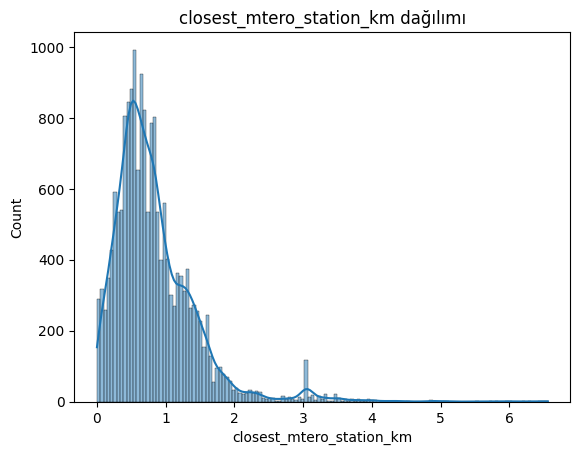

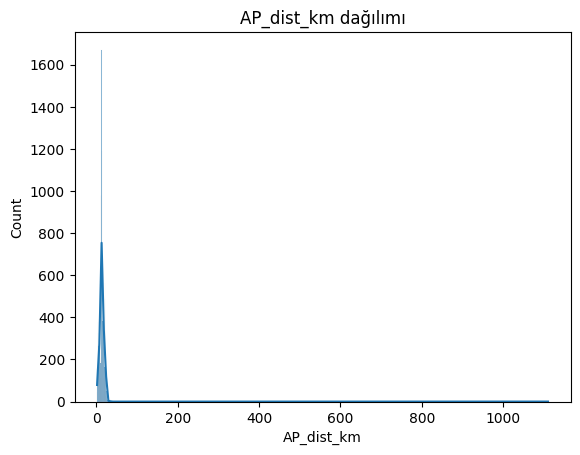

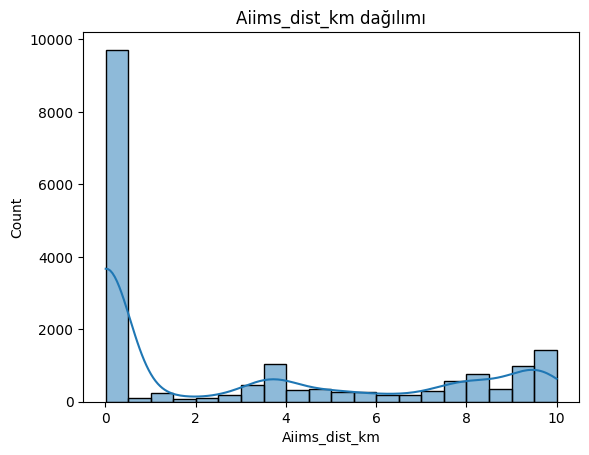

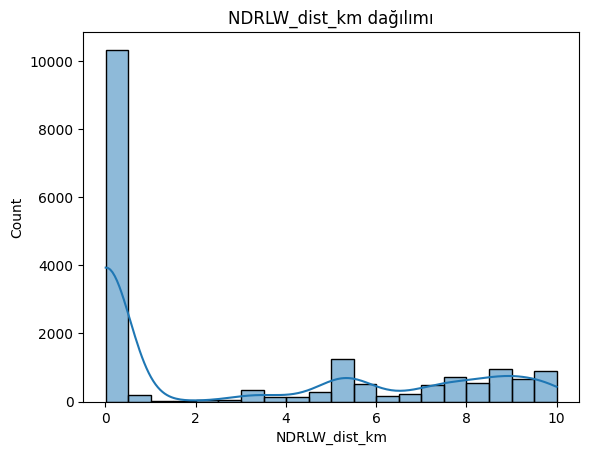

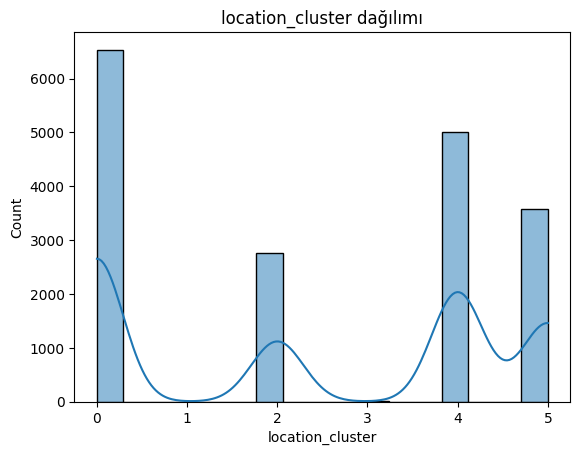

In [19]:
for col in df.select_dtypes(include='number').columns:
    sns.histplot(df[col], kde=True)
    plt.title(f"{col} dağılımı")
    plt.show()

# Aykırı Değerlerin İşlenmesi

In [20]:
df['price'] = np.log1p(df['price'])
df['size_sq_ft'] = np.log1p(df['size_sq_ft'])

In [21]:
df = df[(df['latitude'] >= 28.5) & (df['latitude'] <= 28.7)]
df = df[(df['longitude'] >= 76.9) & (df['longitude'] <= 77.35)]

In [22]:
cols_to_winsorize = ['size_sq_ft', 'closest_mtero_station_km', 'AP_dist_km', 'Aiims_dist_km', 'NDRLW_dist_km']

for col in cols_to_winsorize:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower, upper)

In [23]:
df['bedrooms'] = df['bedrooms'].apply(lambda x: 10 if x > 10 else x)

In [24]:
aykiri_sutunlar = []

for col in df.select_dtypes(include='number').columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    alt_sinir = Q1 - 1.5 * IQR
    ust_sinir = Q3 + 1.5 * IQR
    aykiri_sayisi = df[(df[col] < alt_sinir) | (df[col] > ust_sinir)].shape[0]
    
    if aykiri_sayisi > 0:
        aykiri_sutunlar.append((col, aykiri_sayisi))

# Sonuçları gör
for col, count in aykiri_sutunlar:
    print(f"{col} sütununda {count} aykırı değer var.")

bedrooms sütununda 19 aykırı değer var.
price sütununda 403 aykırı değer var.


In [25]:
cols_to_filter = ['price', 'bedrooms']

for col in cols_to_filter:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]

In [26]:
aykiri_sutunlar = []

for col in df.select_dtypes(include='number').columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    alt_sinir = Q1 - 1.5 * IQR
    ust_sinir = Q3 + 1.5 * IQR
    aykiri_sayisi = df[(df[col] < alt_sinir) | (df[col] > ust_sinir)].shape[0]
    
    if aykiri_sayisi > 0:
        aykiri_sutunlar.append((col, aykiri_sayisi))

# Sonuçları gör
for col, count in aykiri_sutunlar:
    print(f"{col} sütununda {count} aykırı değer var.")

size_sq_ft sütununda 2 aykırı değer var.


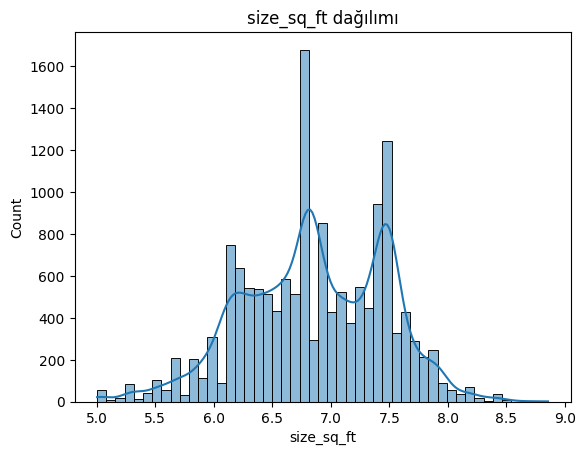

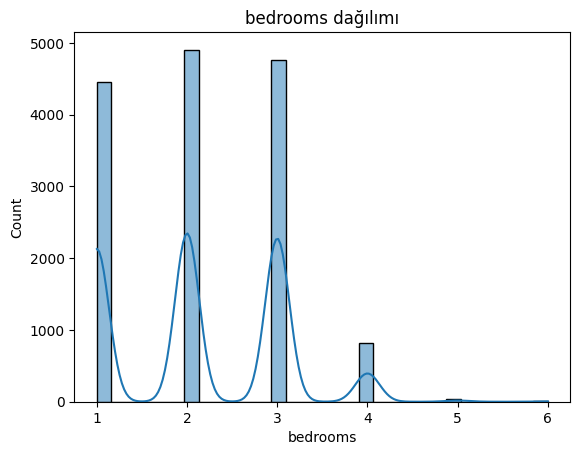

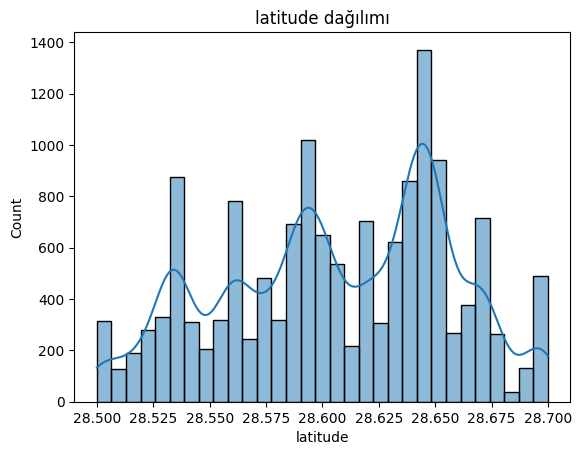

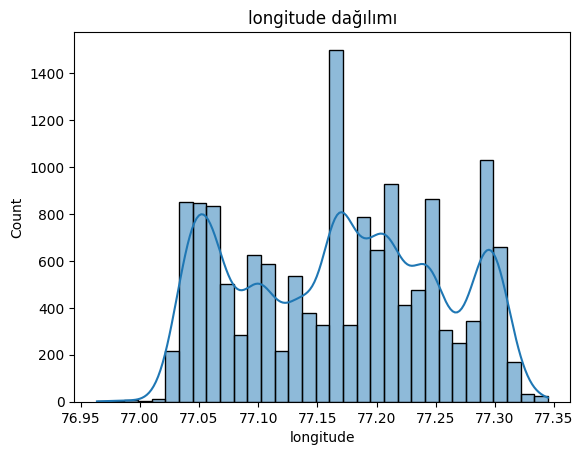

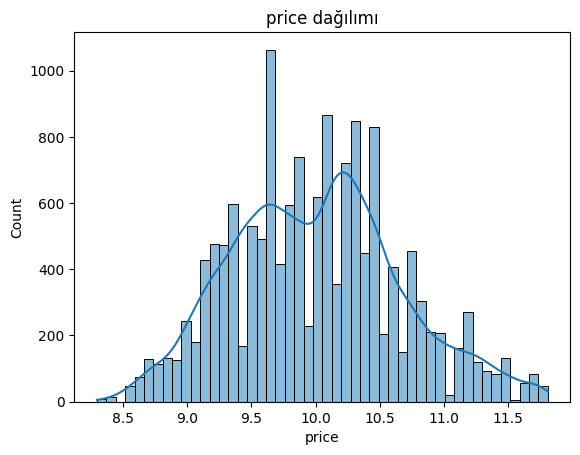

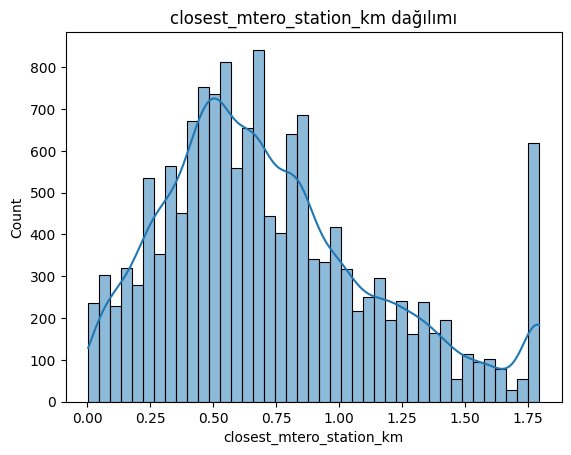

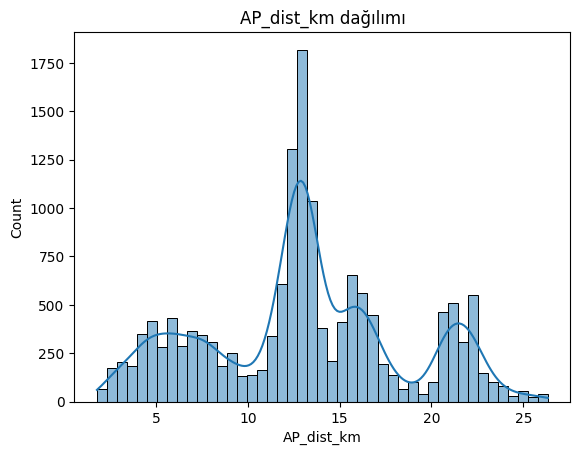

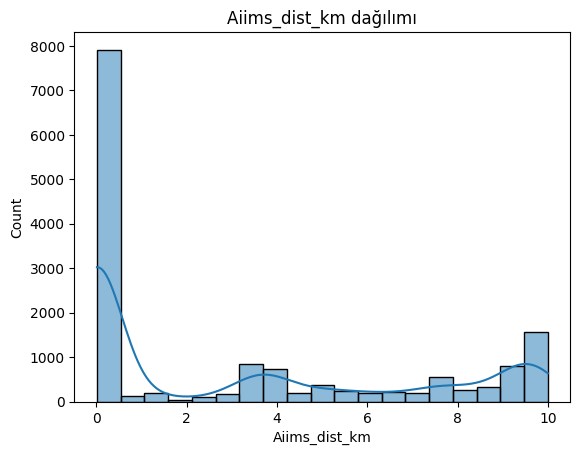

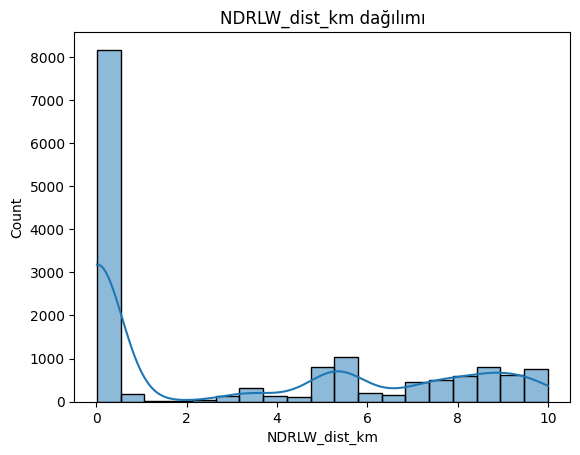

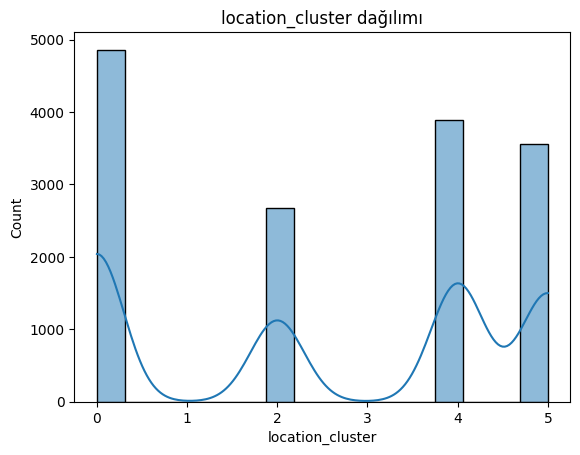

In [27]:
for col in df.select_dtypes(include='number').columns:
    sns.histplot(df[col], kde=True)
    plt.title(f"{col} dağılımı")
    plt.show()

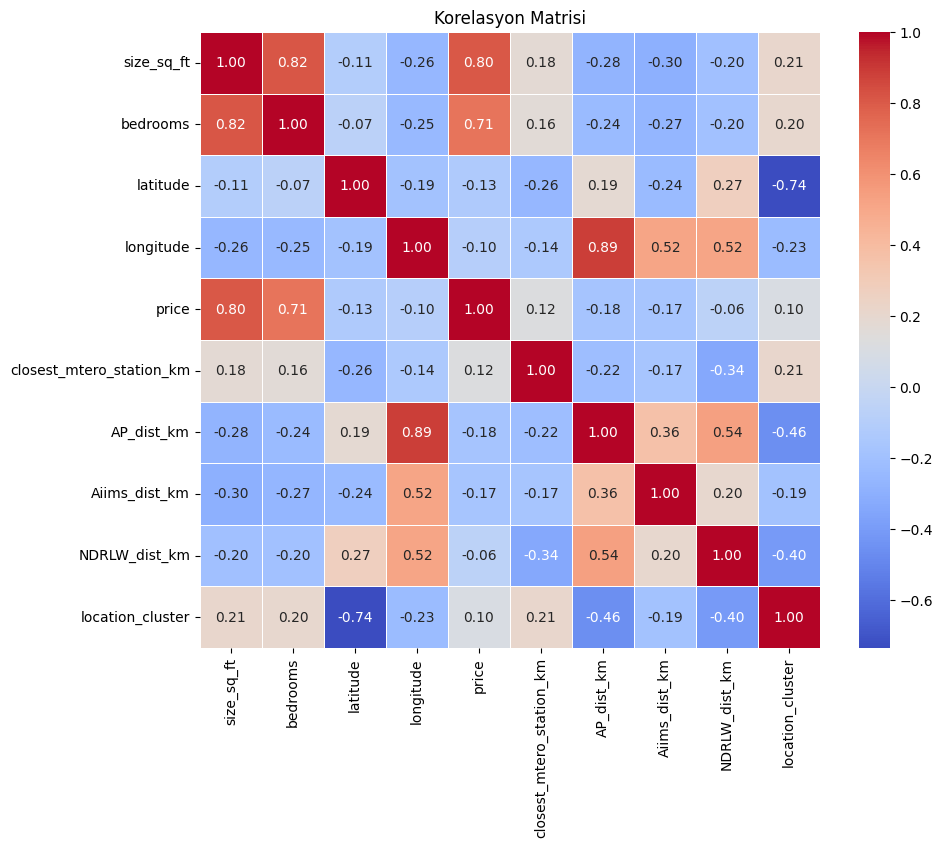

In [28]:
numeric_df = df.select_dtypes(include=['float64', 'int64', 'int32', 'int16', 'int8'])

corr = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Korelasyon Matrisi")
plt.show()

# Train ve Test Veri Setinin Oluşturulması

In [29]:
X = df.drop('price', axis=1)
y = df['price']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standartisazyon

In [31]:
numeric_cols = [
    'closest_mtero_station_km',
    'AP_dist_km', 'Aiims_dist_km', 'NDRLW_dist_km','size_sq_ft','location_cluster',
]

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Lineer Regresyon

In [38]:
param_grid = {
    'fit_intercept': [True, False],
}
lr = LinearRegression()

grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train_scaled.ravel())
best_lr = grid_search.best_estimator_

MAPE: 22.23%
RMSE: 9508.41
R² Skoru: 0.7890
                                 feature  importance
3                              longitude        6.57
2                               latitude        4.98
33             locality_'Rajinder Nagar'        0.94
42                   locality_Chattarpur        0.70
40                locality_'laxmi nagar'        0.67
..                                   ...         ...
62  company_'truelink investor solution'        0.01
56           company_'Prince Associates'        0.01
6                          Aiims_dist_km        0.00
65                         company_other        0.00
54         company_'Jagdamba Associates'        0.00

[67 rows x 2 columns]


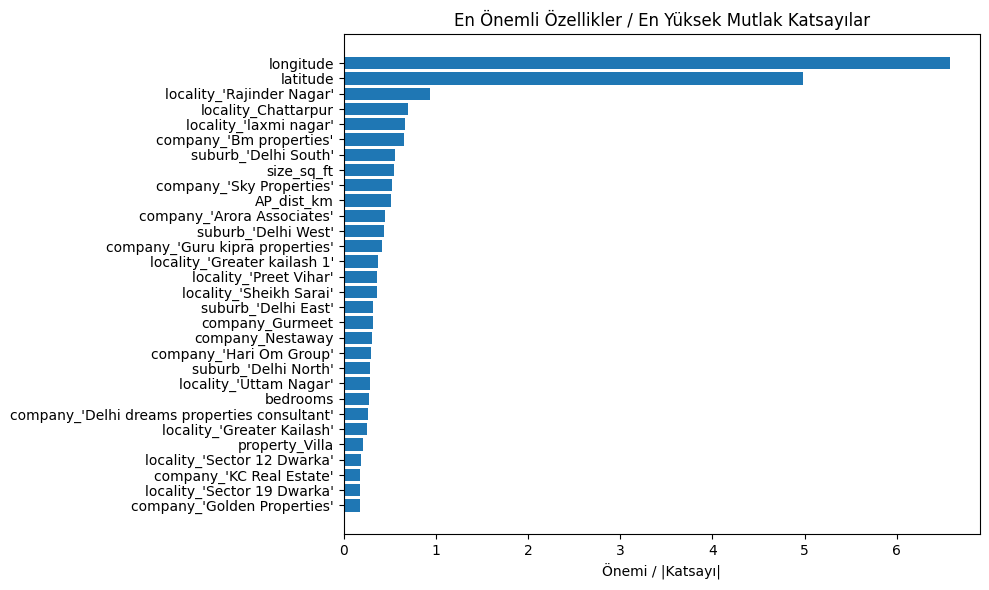

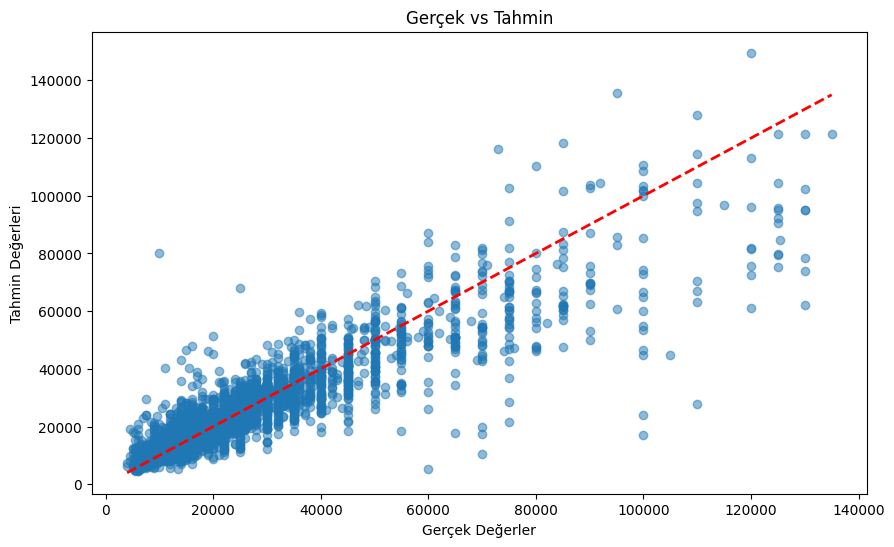

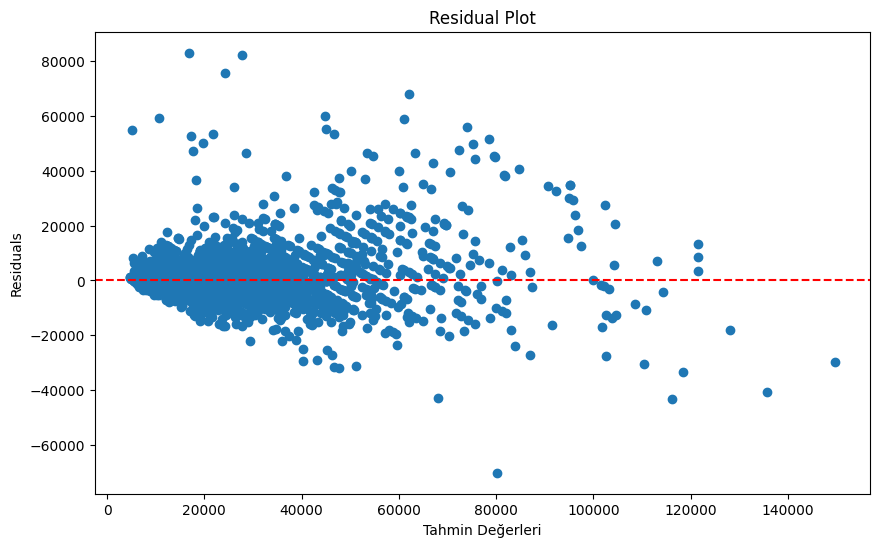

In [39]:
results = evaluate_and_plot(
    model=best_lr,
    X_train=X_train,
    X_test=X_test,
    y_train_scaled=y_train_scaled,
    y_test_scaled=y_test_scaled,
    scaler_y=scaler_y,
    feature_selection=False,
	random_state=42
)

In [43]:
intercept_scaled = best_lr.intercept_
intercept_log = scaler_y.inverse_transform([[intercept_scaled]])[0][0]
intercept_real = np.expm1(intercept_log)

X_mean = pd.DataFrame([X_train.mean()])
y_pred_mean = best_lr.predict(X_mean)

y_pred_mean_unscaled = scaler_y.inverse_transform(y_pred_mean.reshape(-1,1))
baseline_price = np.expm1(y_pred_mean_unscaled[0][0])
print("Ortalama özellikler için tahmin:", baseline_price)

Ortalama özellikler için tahmin: 22173.26015776367


# Ridge Regresyon

In [68]:
param_grid = {
    "alpha": [0.01, 0.1, 0.2, 0.3]
}

ridge = Ridge()

grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train_scaled.ravel())
best_ridge = grid_search.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [69]:
print("En iyi Ridge parametreleri:", grid_search.best_params_)

En iyi Ridge parametreleri: {'alpha': 0.01}


Seçilen özellik sayısı: 59
En iyi özellikler: ['size_sq_ft', 'bedrooms', 'latitude', 'longitude', 'closest_mtero_station_km', 'AP_dist_km', 'NDRLW_dist_km', "suburb_'Delhi Central'", "suburb_'Delhi East'", "suburb_'Delhi North'", "suburb_'Delhi South'", "suburb_'Delhi West'", "suburb_'North Delhi'", "suburb_'North West Delhi'", "suburb_'South West Delhi'", "suburb_'West Delhi'", 'suburb_Dwarka', 'suburb_Other', 'suburb_Rohini', "property_'Independent Floor'", "property_'Independent House'", 'property_Apartment', 'property_Villa', "locality_'Greater Kailash'", "locality_'Greater kailash 1'", "locality_'Karol Bagh'", "locality_'Lajpat Nagar'", "locality_'Malviya Nagar'", "locality_'New Ashok Nagar'", "locality_'Paschim Vihar'", "locality_'Patel Nagar'", "locality_'Preet Vihar'", "locality_'Rajinder Nagar'", "locality_'Ramesh Nagar'", "locality_'Sector 12 Dwarka'", "locality_'Sector 19 Dwarka'", "locality_'Sheikh Sarai'", "locality_'Uttam Nagar'", "locality_'laxmi nagar'", "locality_'mayu

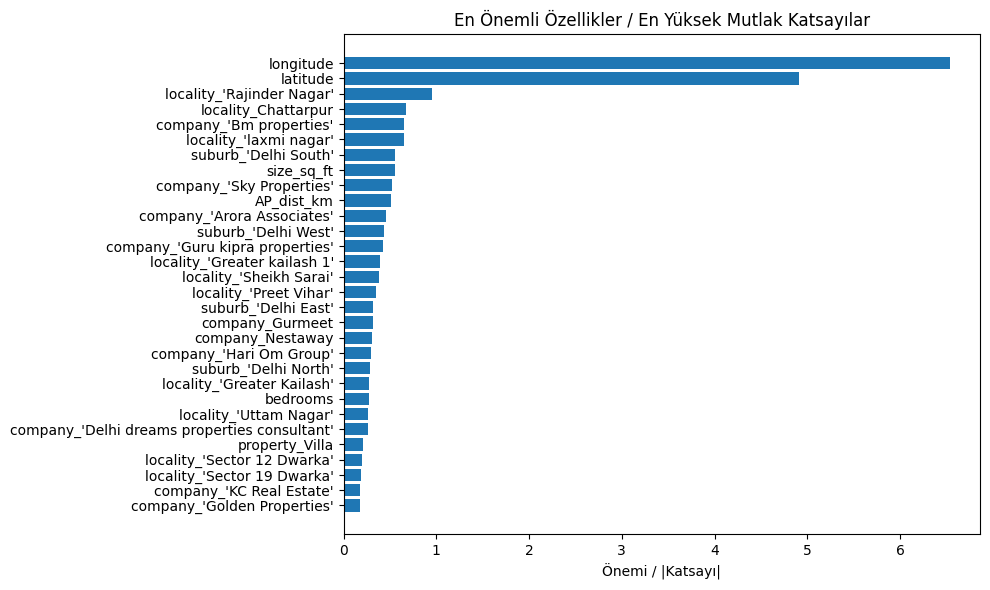

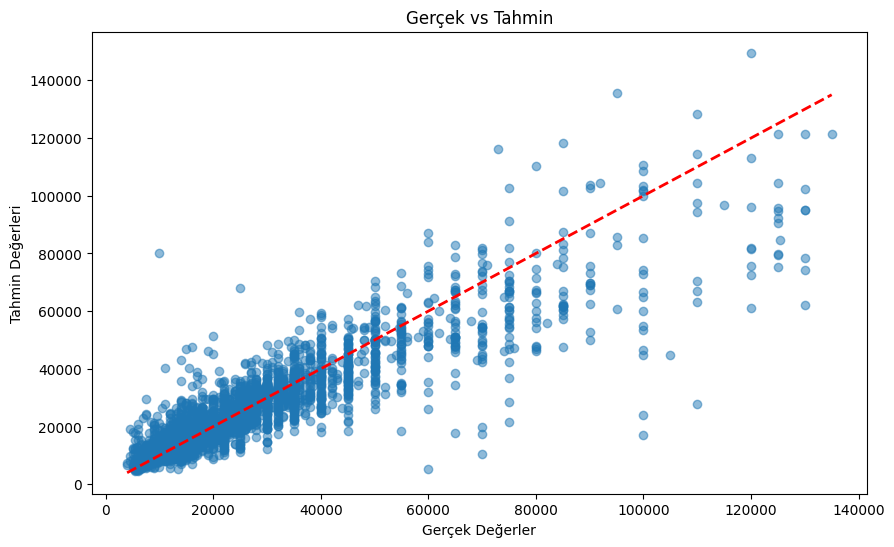

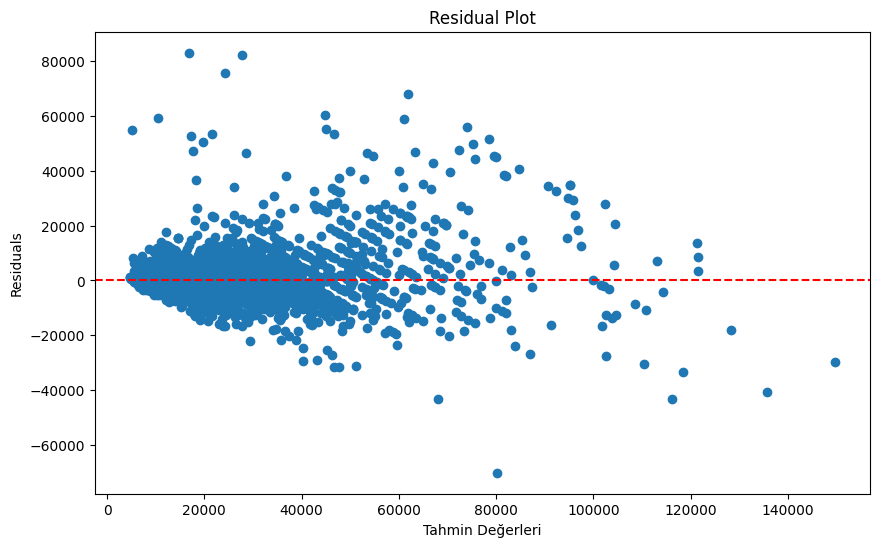

In [ ]:
results = evaluate_and_plot(
    model=best_ridge,
    X_train=X_train,
    X_test=X_test,
    y_train_scaled=y_train_scaled,
    y_test_scaled=y_test_scaled,
    scaler_y=scaler_y,
    feature_selection=True
)

In [47]:
intercept_scaled = best_ridge.intercept_
intercept_log = scaler_y.inverse_transform([[intercept_scaled]])[0][0]
intercept_real = np.expm1(intercept_log)

X_mean = pd.DataFrame([X_train.mean()])
y_pred_mean = best_lr.predict(X_mean)

y_pred_mean_unscaled = scaler_y.inverse_transform(y_pred_mean.reshape(-1,1))
baseline_price = np.expm1(y_pred_mean_unscaled[0][0])
print("Ortalama özellikler için tahmin:", baseline_price)

Ortalama özellikler için tahmin: 22173.26015776367


# Random Forest

In [ ]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth':    [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
	'max_samples': [0.7, 0.8, 0.9],
    'ccp_alpha': [0.0, 0.01, 0.1]  
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,              
    scoring='neg_mean_squared_error',
    cv=3,                    
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [49]:
random_search.fit(X_train, y_train_scaled.ravel())
best_rf = random_search.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END ccp_alpha=0.0, max_depth=30, max_features=sqrt, max_samples=0.8, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END ccp_alpha=0.1, max_depth=40, max_features=sqrt, max_samples=0.9, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END ccp_alpha=0.1, max_depth=40, max_features=sqrt, max_samples=0.9, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END ccp_alpha=0.1, max_depth=40, max_features=sqrt, max_samples=0.9, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END ccp_alpha=0.0, max_depth=30, max_features=sqrt, max_samples=0.8, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END ccp_alpha=0.0, max_depth=30, max_features=sqrt, max_samples=0.8, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END ccp_alpha=0.01, m

Seçilen özellik sayısı: 25
En iyi özellikler: ['size_sq_ft', 'bedrooms', 'latitude', 'longitude', 'closest_mtero_station_km', 'AP_dist_km', 'Aiims_dist_km', 'NDRLW_dist_km', "suburb_'Delhi Central'", "suburb_'Delhi East'", "suburb_'Delhi South'", "suburb_'West Delhi'", 'suburb_Dwarka', 'suburb_Other', "property_'Independent Floor'", 'property_Apartment', "locality_'Greater kailash 1'", "locality_'New Ashok Nagar'", "locality_'Rajinder Nagar'", "locality_'Uttam Nagar'", "locality_'laxmi nagar'", 'locality_Chattarpur', 'locality_other', 'company_other', 'location_cluster']
MAPE: 17.68%
RMSE: 7786.96
R² Skoru: 0.8585
                         feature  importance
0                     size_sq_ft        0.38
1                       bedrooms        0.22
2                       latitude        0.07
3                      longitude        0.06
5                     AP_dist_km        0.06
6                  Aiims_dist_km        0.05
7                  NDRLW_dist_km        0.04
10          suburb

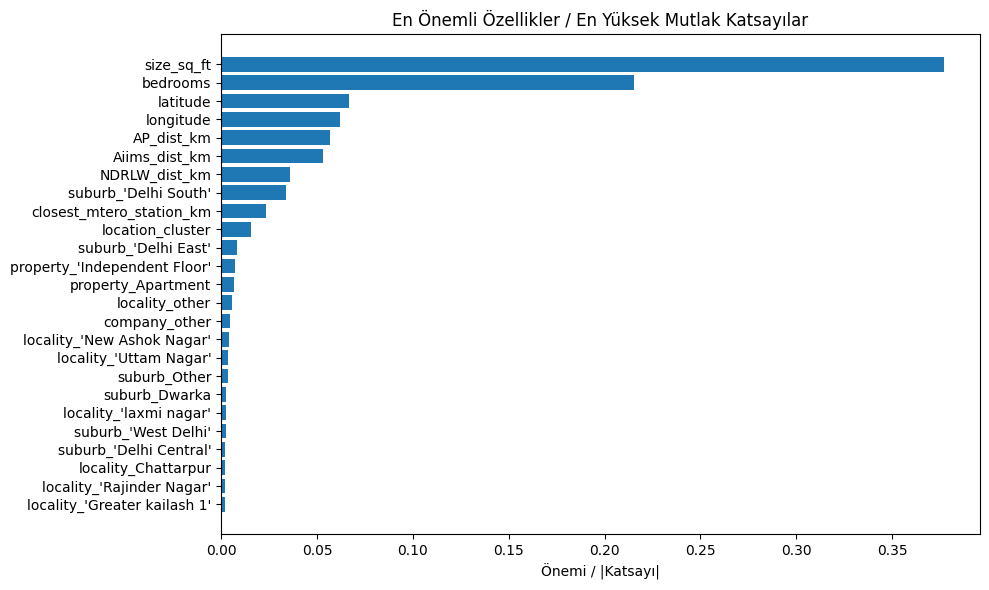

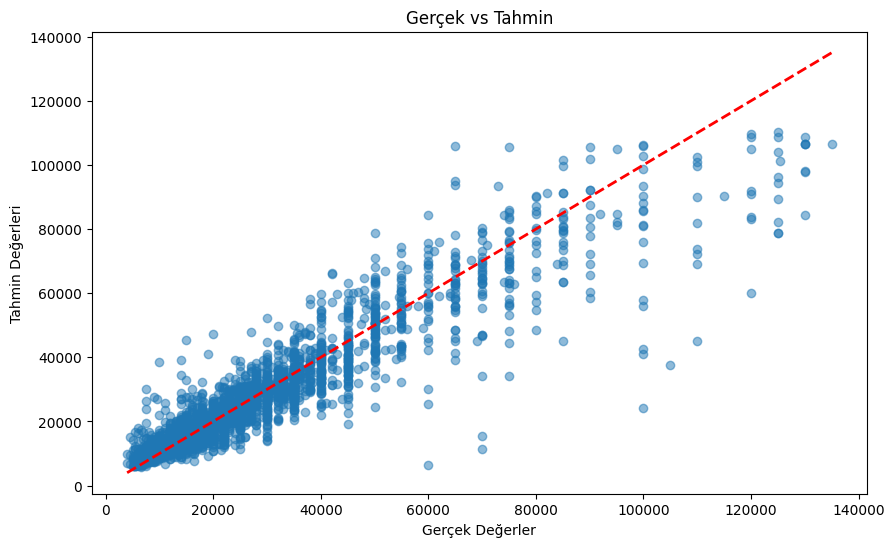

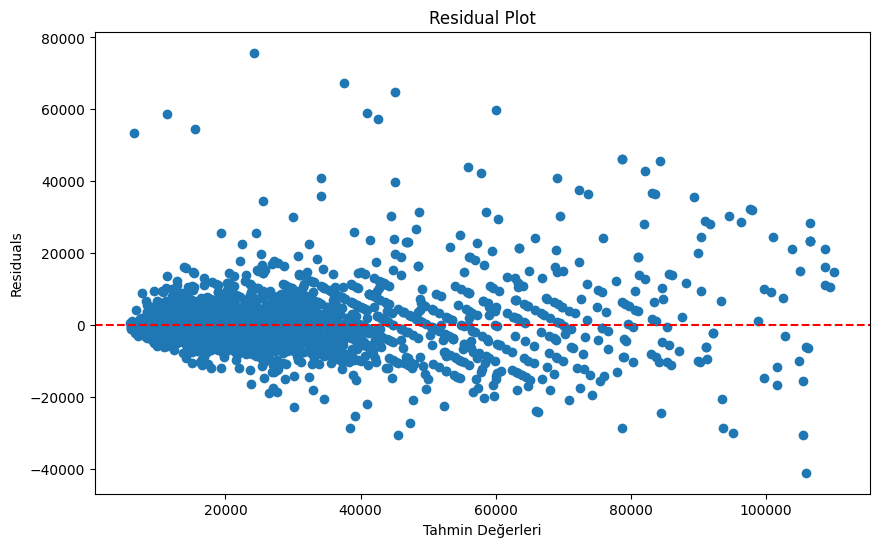

In [ ]:
results = evaluate_and_plot(
    model=best_rf,
    X_train=X_train,
    X_test=X_test,
    y_train_scaled=y_train_scaled,
    y_test_scaled=y_test_scaled,
    scaler_y=scaler_y,
    feature_selection=True 
)

# XGB

In [ ]:
param_grid = {
    "learning_rate": [0.01, 0.1, 0.2],  
    "max_depth": [4, 5, 6],              
    "n_estimators": [350, 400,500],     
    "subsample": [0.8, 1.0],           
    "colsample_bytree": [0.6,0.8,0.7]         
}

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  
    cv=5, 
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train_scaled.ravel())
best_xgb = grid_search.best_estimator_

Fitting 5 folds for each of 162 candidates, totalling 810 fits


Seçilen özellik sayısı: 53
En iyi özellikler: ['size_sq_ft', 'bedrooms', 'latitude', 'longitude', 'closest_mtero_station_km', 'AP_dist_km', 'Aiims_dist_km', 'NDRLW_dist_km', "suburb_'Delhi Central'", "suburb_'Delhi East'", "suburb_'Delhi South'", "suburb_'Delhi West'", "suburb_'North Delhi'", "suburb_'South West Delhi'", "suburb_'West Delhi'", 'suburb_Dwarka', 'suburb_Other', "property_'Independent Floor'", "property_'Independent House'", 'property_Apartment', "locality_'Greater Kailash'", "locality_'Greater kailash 1'", "locality_'Karol Bagh'", "locality_'Lajpat Nagar'", "locality_'Malviya Nagar'", "locality_'Patel Nagar'", "locality_'Preet Vihar'", "locality_'Rajinder Nagar'", "locality_'Ramesh Nagar'", "locality_'Sector 12 Dwarka'", "locality_'Sector 19 Dwarka'", "locality_'Sheikh Sarai'", "locality_'Uttam Nagar'", "locality_'laxmi nagar'", "locality_'mayur vihar phase 1'", 'locality_Chattarpur', 'locality_other', "company_'Arora Associates'", "company_'Bm properties'", "company_'De

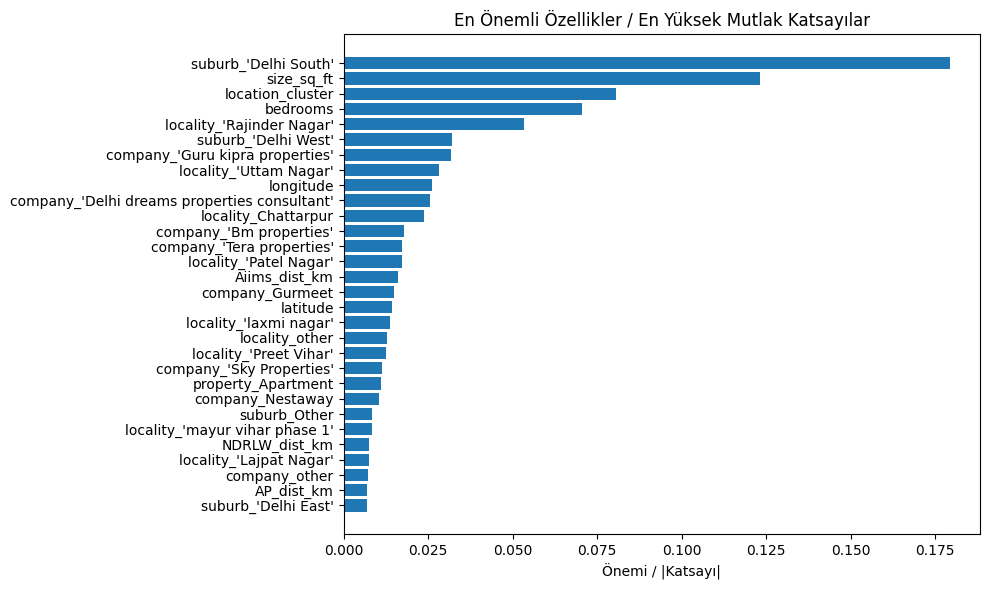

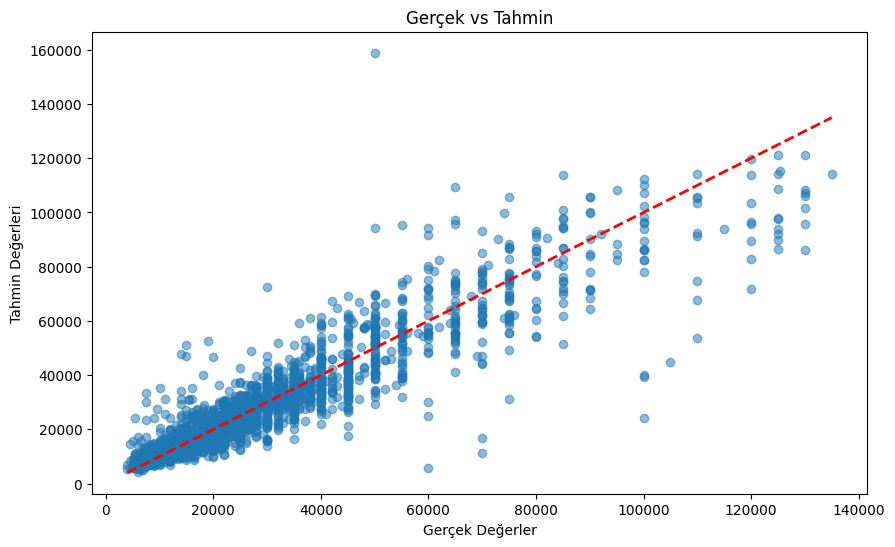

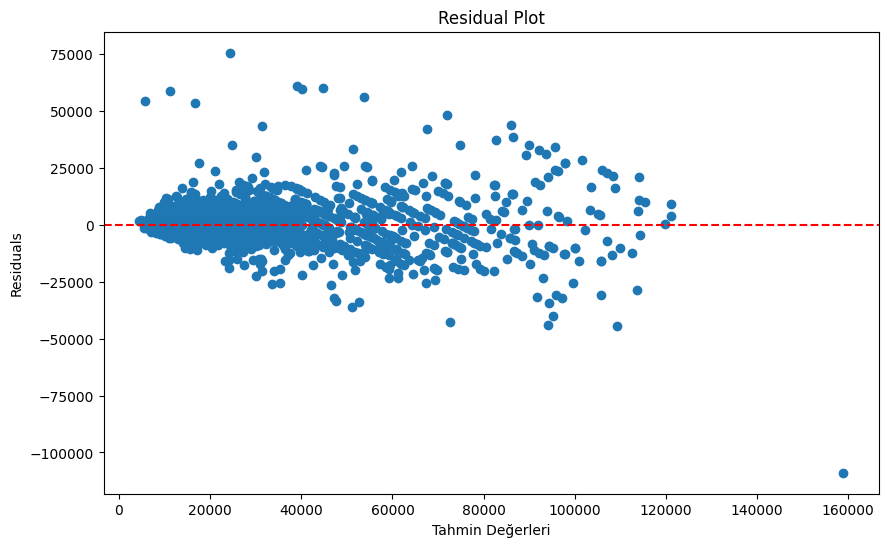

In [54]:
results = evaluate_and_plot(
    model=best_xgb,
    X_train=X_train,
    X_test=X_test,
    y_train_scaled=y_train_scaled,
    y_test_scaled=y_test_scaled,
    scaler_y=scaler_y,
    feature_selection=True
)

# Yapay Sinir Ağı

In [55]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(1)) 

model.compile(optimizer='adam', loss='mse')
history = model.fit(
    X_train, y_train_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Tahmin ve değerlendirme
y_pred_scaled = model.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

y_pred_log = scaler_y.inverse_transform(y_pred_scaled)
y_pred_price = np.expm1(y_pred_log)
y_test_log = scaler_y.inverse_transform(y_test_scaled)
y_test_price = np.expm1(y_test_log)

mse = mean_squared_error(y_test_price, y_pred_price)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_price, y_pred_price)
r2 = r2_score(y_test_price, y_pred_price)

print("MAPE:", mape * 100, "%")
print("RMSE:", rmse)
print("R² Skoru:", r2)

Epoch 1/50


/Users/ekose/Desktop/DFA/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - loss: 0.5765 - val_loss: 0.2287
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 0.2654 - val_loss: 0.2304
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 0.2280 - val_loss: 0.2265
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 0.2461 - val_loss: 0.2129
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - loss: 0.2312 - val_loss: 0.2051
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 0.2132 - val_loss: 0.2966
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 0.2416 - val_loss: 0.2055
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 0.2159 - val_loss: 0.2087
Epoch 9/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 0.2031 - val_loss: 0.2201
Epoch 10/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 0.2144 - val_loss: 0.2015
Epoch 11/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 0.2118 - val_loss: 0.2025
Epoch 12/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 

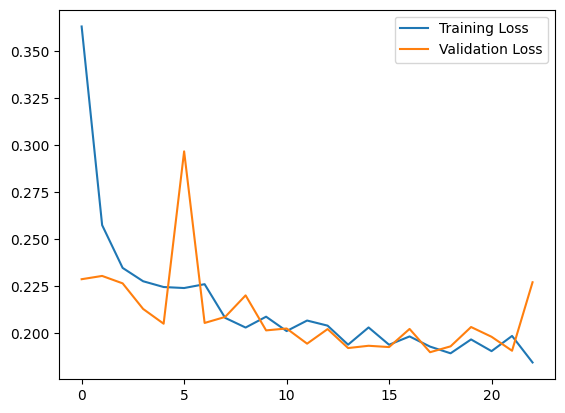

In [56]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()